<a href="https://colab.research.google.com/github/nihardalal/supernovacosmology/blob/main/SupernovaCosmology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages


In [ ]:
import pandas as pd #pandas is a data reading library
import numpy as np #numpy is a math operation library - very useful
import os #os lets you interact with the operating system
from astropy import cosmology #astropy is an astronomy package with lots of useful tools
import matplotlib.pyplot as plt # matplotlib is a standard plotting library
from scipy.optimize import curve_fit #scipy has various modules useful for scientific computing and data analysis
from scipy import stats

# Reading and Plotting the data!

In [ ]:
#The file in folder "data" called "supernova_data.txt" was taken from https://supernova.lbl.gov/union/ and contains
# a list of supernova, their names, redshifts, distance moduli, the error on the distance modulus, and some other
# qualities we don't care about for this project! We're going to read the columns from the txt file into a pandas
# data frame called "df"
df = pd.read_csv('./data/supernova_data.txt', sep = "	", skiprows = [0,1,2,3,4],
                 names = ["SN name", "Redshift", "Distance Modulus", "Distance Modulus Error", "Low Mass Gal Prob"])

To access different columns from the dataframe, use "df[_name_]"

Text(0, 0.5, 'Distance Modulus')

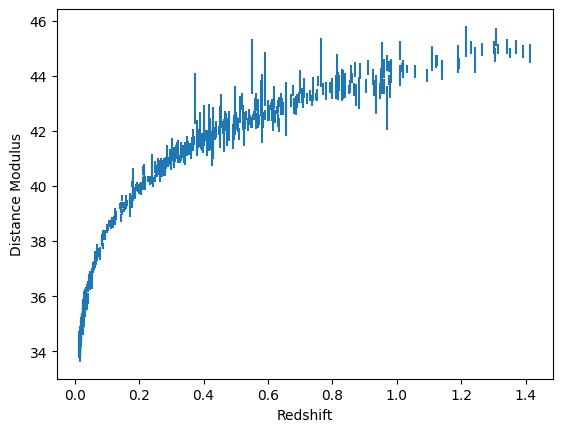

In [ ]:
#Lets make a plot with errorbars!
plt.errorbar(df["Redshift"], df["Distance Modulus"], df["Distance Modulus Error"], ls = '')
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")

# Doing some science


In [ ]:
#We want to model the distance modulus "m" as a function of redshift "z". The math will be explained later, but
# the nice thing about astropy is that the model is already in there for us. However, we need to specify a cosmology
# which for our purposes depends on two additional parameters, "Om" and "H0". See the readup for more!
def m(z, Om, H0):
    if Om<0: return 0
    return cosmology.FlatLambdaCDM(H0, Om).distmod(z).value

Now that we have a model, lets try to fit it just like we would fit a line. Scipy.curve_fit finds the best fit curve to a series of points. The code block below will show you how to do it. It returns popt and pcov, where popt is the optimal set of parameters, and pcov gives an error on the parameters

In [ ]:
xdata = np.array(df['Redshift'])
ydata = np.array(df['Distance Modulus'])
yerr = np.array(df['Distance Modulus Error'])

popt, pcov = curve_fit(m, xdata, ydata, sigma = yerr, p0 = (0.1, 100))

In [ ]:
print(popt)
print(pcov)

[ 0.27761215 70.00241648]
[[ 0.00036909 -0.0047665 ]
 [-0.0047665   0.11357085]]


Lets also generate a curve that would look like a universe with 70% dark energy, and see what that looks like, and if it fits the data well

In [ ]:
expected_m_array = [m(z, 0.3, 70) for z in np.sort(df["Redshift"])]

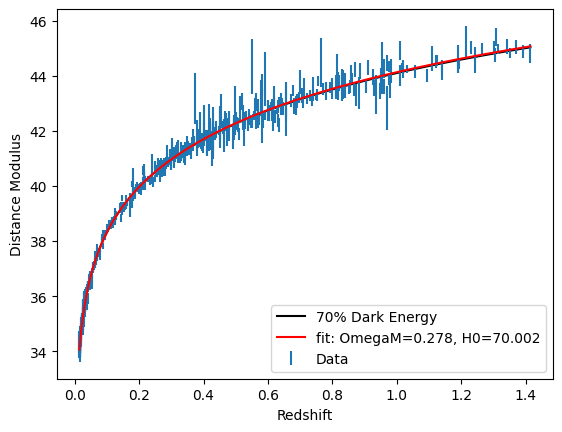

In [ ]:
plt.plot(np.sort(df["Redshift"]), expected_m_array, c= 'k', label = "70% Dark Energy")
plt.errorbar(df["Redshift"], df["Distance Modulus"], df["Distance Modulus Error"], ls = '', label = "Data")
plt.plot(np.sort(xdata), m(np.sort(xdata), *popt), 'r-',label='fit: OmegaM=%5.3f, H0=%5.3f' % tuple(popt))
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.legend()

Seems like our data fits quite well, and our guesses were pretty solid. Play around with this plot to see if you can generate some more interesting universes. For example, what would one without any dark energy look like?

# MCMC

In practice, when our models have a lot of parameters and are hard to evaluate, regular curve fitting doesn't work as well, and takes too long. We use a technique called Markov Chain Monte Carlo (MCMC) to find the best fit model parameters to some data, and also get a good estimate on the errors on the parameters.

MCMC is a pretty advanced technique, and the math behind it is pretty complicated. A basic explanation is that you're asking the computer to just try things randomly again and again in a clever way where the computer gets closer to the correct answer every time (kind of like playing hot and cold). If you're interested in this, check out this video by Veritasium (about Markov Chains): https://www.youtube.com/watch?v=KZeIEiBrT_w

You can also explore more by reading about Bayesian Statistics

In [ ]:
#We need to start by installing another package called emcee which does mcmc for us
!pip install emcee

In [ ]:
#Now that the package is installed, lets import it.
import emcee

In [ ]:
#Parameters need a prior range - kind of a guess for what we think a reasonable place to guess is.
#For now, these priors are pretty wide, but feel free to mess around with them.
def log_prior(theta):
    omega_m, h_0 = theta
    if 0<= omega_m <=1 and 0 <= h_0 <=1000: #prior on omega_m puts it between 0 and 1, prior on H0 between 0 and 1000
        return 0
    return -np.inf

In [ ]:
#The actual magic happens here - this is the log likelihood which defines how well the model fits the data
#Evaluate the model at a given set of parameters, and then compare it to the actual data, dividing by the error
# and summing the square because we want to weight positive and negative deviations equally
def log_likelihood(theta, x, y, yerr):
    omega_m, h_0 = theta
    model = m(x, omega_m, h_0)
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

In [ ]:
#Combine the prior and the likelihood into one probability.
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [ ]:
#For a first guess, we're going to try to find the maximum of the likelihood using scipy.
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([np.random.uniform(), np.random.uniform(low = 0, high = 100)])
soln = minimize(nll, initial, args=(xdata, ydata, yerr))
o_m, h_0 = soln.x

print("Maximum likelihood estimates:")
print("Omega_m = {0:.3f}".format(o_m))
print("H_0 = {0:.3f}".format(h_0))


Maximum likelihood estimates:
Omega_m = 0.013
H_0 = 95.050


In [ ]:
#Now that we have a starting point, lets let emcee do the magic.
#WARNING: this cell will take a while to execute, given that emcee is trying a bunch of things. Be prepared.
#You can mess with the ntrials variable to speed this up/slow it down, but a larger ntrials is much more accurate

import multiprocessing

ntrials = 1000

pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

# Use multiprocessing to speed up the sampler
with multiprocessing.Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(xdata, ydata, yerr), pool=pool
    )
    sampler.run_mcmc(pos, ntrials, progress=True); #increase to 5000 if needed


100%|██████████| 1000/1000 [10:14<00:00,  1.63it/s]


<>:7: SyntaxWarning: invalid escape sequence '\O'
<>:7: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipython-input-1205104200.py:7: SyntaxWarning: invalid escape sequence '\O'
  labels = ["\Omega_m", "H_0"]


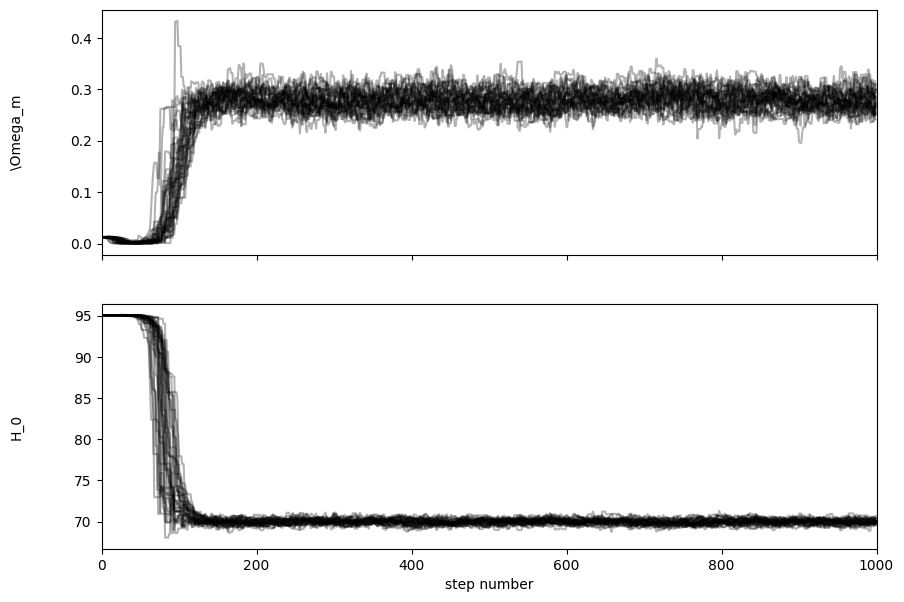

In [ ]:
#Lets check how the computer did - these plots show how the guesses for the parameters changed
#over time. Ideally, they should eventually converge around some value with some random variance
#above and below. You may see something different/inaccurate at the early stages - that corresponds
#to something called burn-in - it takes a while for the computer to converge to the correct answer.
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["\Omega_m", "H_0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
#We transform the output of the "samples" that the computer generated by removing the burn in period
#and also "flattening" the numpy array so its easier for us to work with.
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)
print(flat_samples.shape)

(1440, 2)


In [ ]:
#To see the parameters plotted nicely, we need another package called corner. Lets install it.
!pip install corner

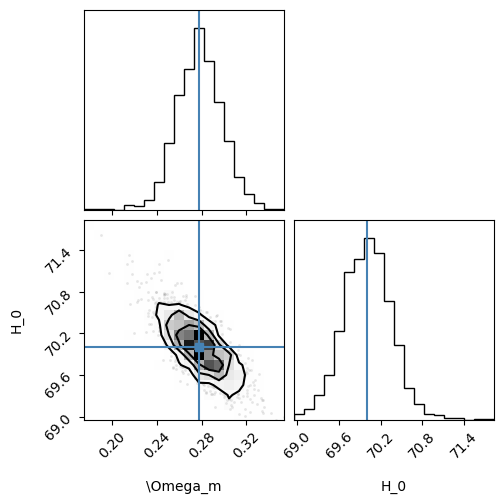

In [ ]:
#import corner that we installed
import corner

#and make a corner plot with it! The corner plot shows you a probabilistic guess for the values of the parameters
#as well as how they may be related to one another
fig = corner.corner(
    flat_samples, labels=labels, truths=[popt[0], popt[1]]
);

/usr/local/lib/python3.12/dist-packages/astropy/cosmology/_src/flrw/base.py:1380: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


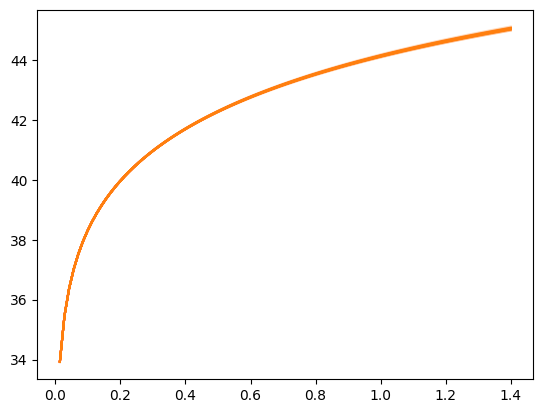

In [ ]:
#as a last bit, lets draw some samples from the mcmc and plot their guesses for the m, z relation
#See how this compares to the data! Did the computer do a good job?
inds = np.random.randint(len(flat_samples), size=100)
x0 = np.linspace(0, 1.4, 100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, m(x0, sample[0], sample[1]), "C1", alpha=0.1)

**Congrats, you did some cosmology!** A lot of these techniques are super useful today in modern cosmology research. If you want to try extending this project, feel free to reach out to me at dalal.64@osu.edu, and I'll be happy to help. Great job!